In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6fGJZmR29pSocBkg8flUDMmciUNsbWyY2RQRCuq-zcflSlk_DQYwk


In [ ]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D,GlobalAveragePooling2D,GlobalAveragePooling1D,GlobalAveragePooling3D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
import math
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Speech Emotion Recognition/Kaggle SER/Data_path_shuffled.csv")

In [ ]:
batch_size=50
label=list(df.labels)
le=LabelEncoder()
le.fit(label)
ids=math.ceil(df.shape[0]/batch_size)
train_ids=182
test_ids=ids-train_ids
print(ids,train_ids,test_ids)

244 182 62


In [ ]:
!pip install -q transformers

     |████████████████████████████████| 2.1MB 11.3MB/s 
     |████████████████████████████████| 901kB 40.5MB/s 
     |████████████████████████████████| 3.3MB 37.5MB/s 


In [ ]:
from transformers import Wav2Vec2FeatureExtractor,Wav2Vec2Processor,Wav2Vec2Model
import torch
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def training_generator(label,le):
  label=label[:9100]
  while 1:
    for i in range(train_ids):
      x=np.load("/content/drive/MyDrive/Speech Emotion Recognition/Kaggle SER/Wav2Vec2Avg_Attention/Training/{}.npy".format(i))
      #x=np.reshape(x,(x.shape[0],x.shape[1],1))
      mean = x.mean(axis=(1,2)).reshape((50,1,1))
      std = x.std(axis=(1,2)).reshape((50,1,1))
      x = (x - mean)/std
      y=label[i*50:(i+1)*50]
      y=np_utils.to_categorical(le.transform(y),num_classes=14)
      yield x,y
def testing_generator(label,le):
  label=label[9100:]
  while 1:
    for i in range(test_ids-1):
      x=np.load("/content/drive/MyDrive/Speech Emotion Recognition/Kaggle SER/Wav2Vec2Avg_Attention/Testing/{}.npy".format(i))
      #x=np.reshape(x,(x.shape[0],x.shape[1],1))
      mean = x.mean(axis=(1,2)).reshape((50,1,1))
      std = x.std(axis=(1,2)).reshape((50,1,1))
      x = (x - mean)/std
      y=label[i*50:(i+1)*50]
      y=np_utils.to_categorical(le.transform(y),num_classes=14)
      yield x,y

In [ ]:
def get_2d_conv_model():
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 14
    inp = Input(shape=(124,768,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)

    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)

    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [ ]:
model = get_2d_conv_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 124, 768, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 124, 768, 32)      1312      
_________________________________________________________________
batch_normalization_5 (Batch (None, 124, 768, 32)      128       
_________________________________________________________________
activation_5 (Activation)    (None, 124, 768, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 384, 32)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 62, 384, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 384, 32)       4099

In [ ]:
hist=model.fit_generator(generator=training_generator(label,le),steps_per_epoch=182,epochs=20,validation_data=testing_generator(label,le),validation_steps=61)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
182/182 [==============================] - 510s 3s/step - loss: 2.5936 - acc: 0.1522 - val_loss: 2.5732 - val_acc: 0.2131
Epoch 2/20
182/182 [==============================] - 420s 2s/step - loss: 1.7256 - acc: 0.4119 - val_loss: 1.5238 - val_acc: 0.5102
Epoch 3/20
182/182 [==============================] - 405s 2s/step - loss: 1.3925 - acc: 0.5211 - val_loss: 1.3019 - val_acc: 0.5911
Epoch 4/20
182/182 [==============================] - 390s 2s/step - loss: 1.2087 - acc: 0.5830 - val_loss: 1.3621 - val_acc: 0.5203
Epoch 5/20
182/182 [==============================] - 369s 2s/step - loss: 1.0999 - acc: 0.6092 - val_loss: 1.3603 - val_acc: 0.5039
Epoch 6/20
182/182 [==============================] - 374s 2s/step - loss: 1.0269 - acc: 0.6308 - val_loss: 1.3363 - val_acc: 0.5089
Epoch 7/20
182/182 [==============================] - 358s 2s/step - loss: 0.9542 - acc: 0.6618 - val_loss: 1.4119 - val_acc: 0.5144
Epoch 8/20
182/182 [==============================] - 386s 2s/step - 

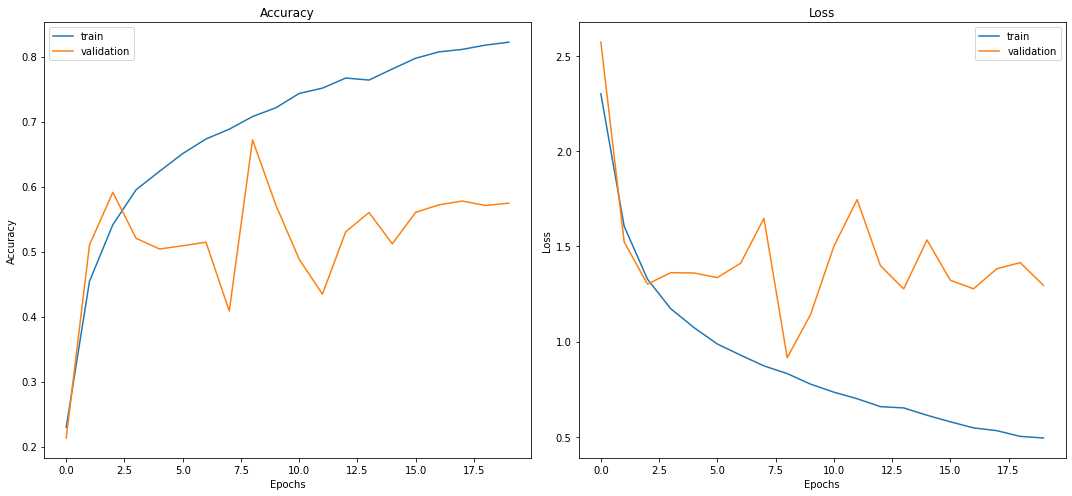

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
actual=list()
j=9100
for i in range(61):
  actual.extend(label[j+(i*50):j+((i+1)*50)])
actual=le.transform(actual)

In [ ]:
pred=list()

for i in range(61):
  x=np.load("/content/drive/MyDrive/Speech Emotion Recognition/Kaggle SER/Wav2Vec2Avg_Attention/Testing/{}.npy".format(i))
  #x=np.reshape(x,(x.shape[0],x.shape[1],1))
  mean = x.mean(axis=(1,2)).reshape((50,1,1))
  std = x.std(axis=(1,2)).reshape((50,1,1))
  x = (x - mean)/std
  x=model.predict(x,batch_size=50,verbose=1)
  x=x.argmax(axis=1)
  pred.extend(x)

1/1 [==============================] - 0s 120ms/step


In [ ]:
print(accuracy_score(actual, pred))

0.5744262295081968


In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


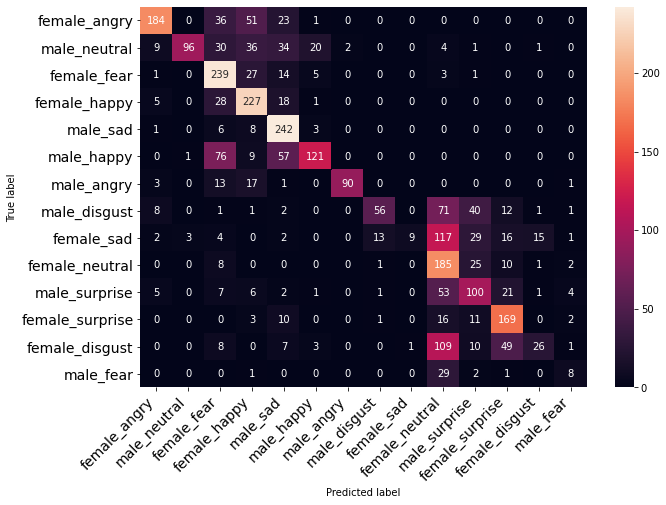

In [ ]:
c = confusion_matrix(actual, pred)
print_confusion_matrix(c, class_names = df['labels'].unique())